**Importing Necessary Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from ydata_profiling import ProfileReport
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

%matplotlib inline

**Loading energy dataset**

In [3]:
energy_df = pd.read_csv('household_power_consumption.csv', delimiter=',')
energy_df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0,1,17.0
1,16/12/2006,17:25:00,5.36,0.436,233.63,23,0,1,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23,0,2,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23,0,1,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0,1,17.0


In [4]:
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Date                   1048575 non-null  object 
 1   Time                   1048575 non-null  object 
 2   Global_active_power    1048575 non-null  object 
 3   Global_reactive_power  1048575 non-null  object 
 4   Voltage                1048575 non-null  object 
 5   Global_intensity       1048575 non-null  object 
 6   Sub_metering_1         1048575 non-null  object 
 7   Sub_metering_2         1048575 non-null  object 
 8   Sub_metering_3         1044506 non-null  float64
dtypes: float64(1), object(8)
memory usage: 72.0+ MB


**Loading and Pre-Processing Weather Data**

In [12]:
weather_df = pd.read_csv('sceaux_weather_data.csv')
weather_df.head()

,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2006-12-01,8.3,4.7,10.0,0.0,NaN,172.0,14.2,NaN,1024.6,NaN
1,2006-12-02,10.2,8.8,11.4,0.0,NaN,187.0,10.6,NaN,1017.1,NaN
2,2006-12-03,9.6,7.7,11.8,0.3,NaN,197.0,19.3,NaN,1008.2,NaN
3,2006-12-04,12.2,8.7,14.5,4.8,NaN,216.0,20.0,NaN,1006.7,NaN
4,2006-12-05,13.3,10.7,15.7,4.3,NaN,201.0,20.7,NaN,1004.5,NaN


In [13]:
# Convert 'time' column to datetime format
weather_df['time'] = pd.to_datetime(weather_df['time'])

In [14]:
# Extract day, month, and year from the time column
weather_df['Year'] = weather_df['time'].dt.year
weather_df['Month'] = weather_df['time'].dt.month
weather_df['Day'] = weather_df['time'].dt.day

**Pre-Processing Energy data**

In [15]:
# Set dtypes
dtypes = {
    'Date': str,
    'Time': str,
    'Global_active_power': float,
    'Global_reactive_power': float,
    'Voltage': float,
    'Global_intensity': float,
    'Sub_metering_1': float,
    'Sub_metering_2': float,
    'Sub_metering_3': float
}
# Load energy data with proper dtypes
energy_df = pd.read_csv('household_power_consumption.csv', dtype=dtypes, delimiter=',', na_values="?")
energy_df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [16]:
# Combine 'Date' and 'Time' into a single datetime column
energy_df['Datetime'] = pd.to_datetime(energy_df['Date'] + ' ' + energy_df['Time'], format='%d/%m/%Y %H:%M:%S')

# Drop original date and time columns to clean up the dataset
energy_df.drop(columns=['Date', 'Time'], inplace=True)
energy_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00


**Merging the Datasets**

In [17]:
# Merge datasets based on the datetime
merged_df = pd.merge(energy_df, weather_df, left_on='Datetime', right_on='time', how='inner')
# Drop the redundant 'time' column from the merged dataset
merged_df.drop(columns=['time'], inplace=True)
merged_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,tavg,tmin,...,prcp,snow,wdir,wspd,wpgt,pres,tsun,Year,Month,Day
0,1.044,0.152,242.73,4.4,0.0,2.0,0.0,2006-12-17,4.4,1.1,...,3.3,NaN,217.0,4.6,NaN,1029.5,NaN,2006,12,17
1,0.278,0.126,246.17,1.2,0.0,2.0,0.0,2006-12-18,4.6,3.4,...,0.0,NaN,125.0,6.5,NaN,1029.0,NaN,2006,12,18
2,0.414,0.242,241.19,2.0,0.0,1.0,0.0,2006-12-19,2.6,0.5,...,0.0,NaN,22.0,14.8,NaN,1034.1,NaN,2006,12,19
3,0.824,0.058,245.57,3.4,0.0,0.0,0.0,2006-12-20,2.9,0.5,...,0.0,NaN,21.0,13.5,NaN,1037.5,NaN,2006,12,20
4,1.814,0.148,243.51,7.6,0.0,0.0,18.0,2006-12-21,5.2,1.7,...,0.0,NaN,23.0,14.5,NaN,1039.4,NaN,2006,12,21


**Checking for missing values**

In [18]:
# Check for missing values
merged_df.isnull().sum()

,0
Global_active_power,2
Global_reactive_power,2
Voltage,2
Global_intensity,2
Sub_metering_1,2
Sub_metering_2,2
Sub_metering_3,2
Datetime,0
tavg,0
tmin,0


In [19]:
# Fill missing values using ffill method
merged_df.fillna(method='ffill', inplace=True)  # Forward fill to maintain continuity
merged_df.info() # Verify that there are no missing values left

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Global_active_power    728 non-null    float64       
 1   Global_reactive_power  728 non-null    float64       
 2   Voltage                728 non-null    float64       
 3   Global_intensity       728 non-null    float64       
 4   Sub_metering_1         728 non-null    float64       
 5   Sub_metering_2         728 non-null    float64       
 6   Sub_metering_3         728 non-null    float64       
 7   Datetime               728 non-null    datetime64[ns]
 8   tavg                   728 non-null    float64       
 9   tmin                   728 non-null    float64       
 10  tmax                   728 non-null    float64       
 11  prcp                   728 non-null    float64       
 12  snow                   251 non-null    float64       
 13  wdir 

**Scaling Features**

In [60]:
# Scale features
features_to_scale = ['Global_active_power', 'Global_reactive_power', 'Voltage',
                     'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
                     'Sub_metering_3', 'tavg', 'tmin', 'tmax', 'Lag_1', 'Lag_60']
scaler = MinMaxScaler()
merged_df[features_to_scale] = scaler.fit_transform(merged_df[features_to_scale]) # Fit and transform the features


In [61]:
# Check the scaled features
merged_df[features_to_scale].describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,tavg,tmin,tmax,Lag_1,Lag_60
count,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000
mean,0.133281,0.187523,0.649840,0.140050,0.015694,0.020134,0.181969,0.506764,0.530002,0.476137,0.133327,0.127622
std,0.164868,0.166238,0.147920,0.162267,0.117019,0.092729,0.359998,0.209261,0.217403,0.207306,0.164842,0.160344
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.033675,0.078231,0.575482,0.043478,0.000000,0.000000,0.000000,0.356115,0.375000,0.317568,0.033675,0.035414
50%,0.057467,0.159864,0.673087,0.069565,0.000000,0.000000,0.000000,0.507194,0.529167,0.475976,0.057467,0.057467
75%,0.212482,0.261905,0.745055,0.217391,0.000000,0.026316,0.052632,0.694245,0.717708,0.642643,0.212482,0.182284
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Remove Rows That Contain NaN**

In [70]:
import pandas as pd

# Load datasets
weather_df = pd.read_csv("sceaux_weather_data.csv")
power_df = pd.read_csv("household_power_consumption.csv")

# Remove rows with NaN
weather_df_clean = weather_df.dropna()
power_df_clean = power_df.dropna()

print("Weather shape after cleaning:", weather_df_clean.shape)
print("Power shape after cleaning:", power_df_clean.shape)

Weather shape after cleaning: (0, 11)
Power shape after cleaning: (1044506, 9)


**Data Visualization**

**Time Series Plot of Global Active Power**

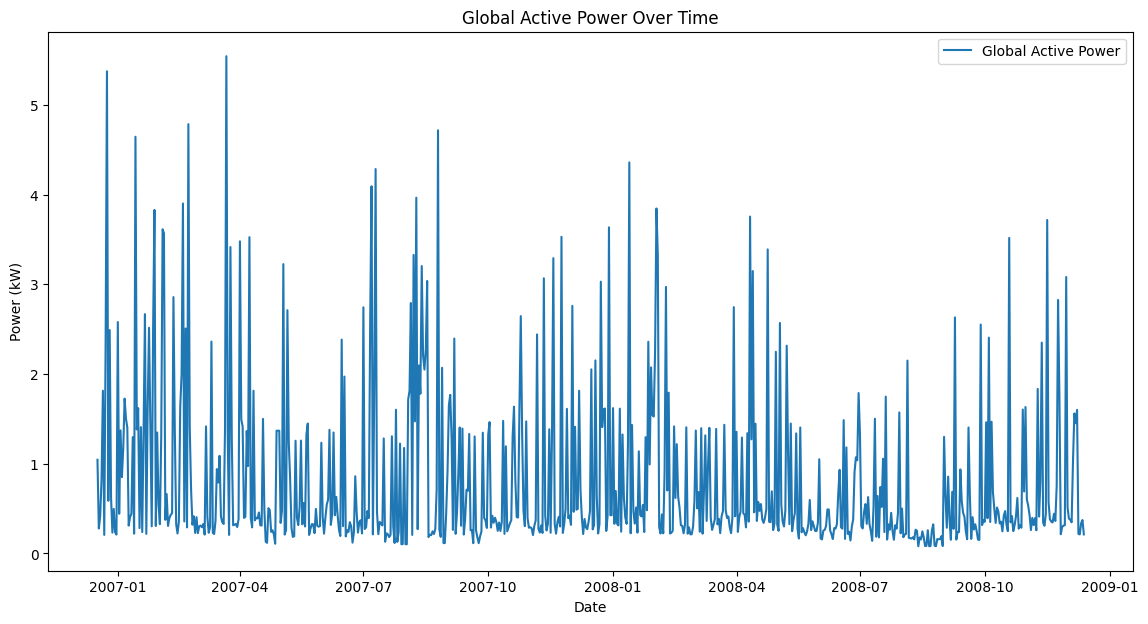

In [22]:
# Set Datetime as index for easier plotting
merged_df.set_index('Datetime', inplace=True)

# Plot Global Active Power over time
plt.figure(figsize=(14, 7))
plt.plot(merged_df['Global_active_power'], label='Global Active Power')
plt.title('Global Active Power Over Time')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.legend()
plt.show()

**Distribution of Energy Consumption**

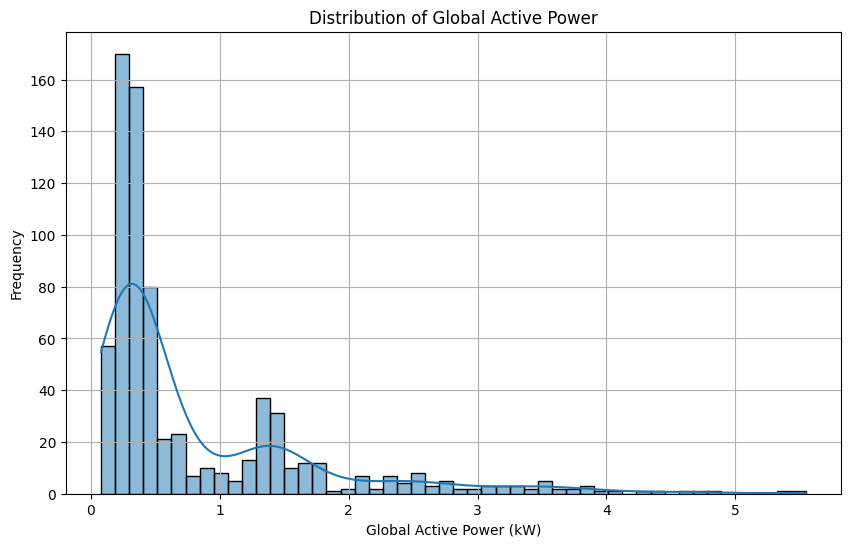

In [23]:
# Visualize the distribution of Global Active Power
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['Global_active_power'], bins=50, kde=True)
plt.title('Distribution of Global Active Power')
plt.xlabel('Global Active Power (kW)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

**Daily Average Consumption**

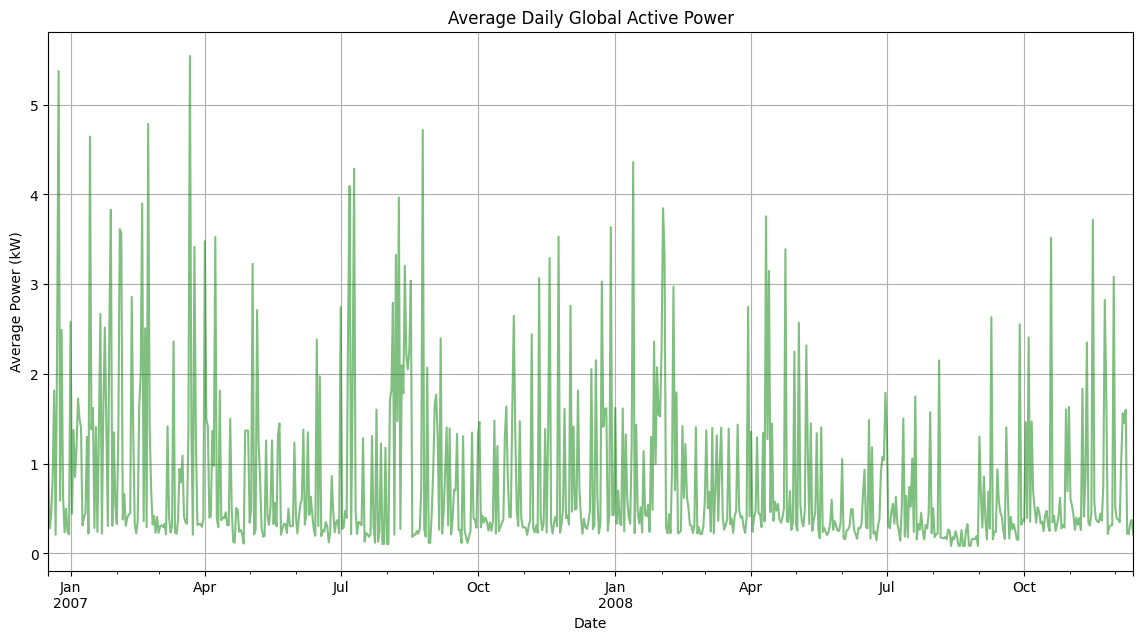

In [24]:
# Calculate daily average consumption
daily_consumption = merged_df['Global_active_power'].resample('D').mean()

# Plot daily average consumption
plt.figure(figsize=(14, 7))
daily_consumption.plot(color='green', alpha=0.5)
plt.title('Average Daily Global Active Power')
plt.xlabel('Date')
plt.ylabel('Average Power (kW)')
plt.grid()
plt.show()

**Monthly Average Consumption**

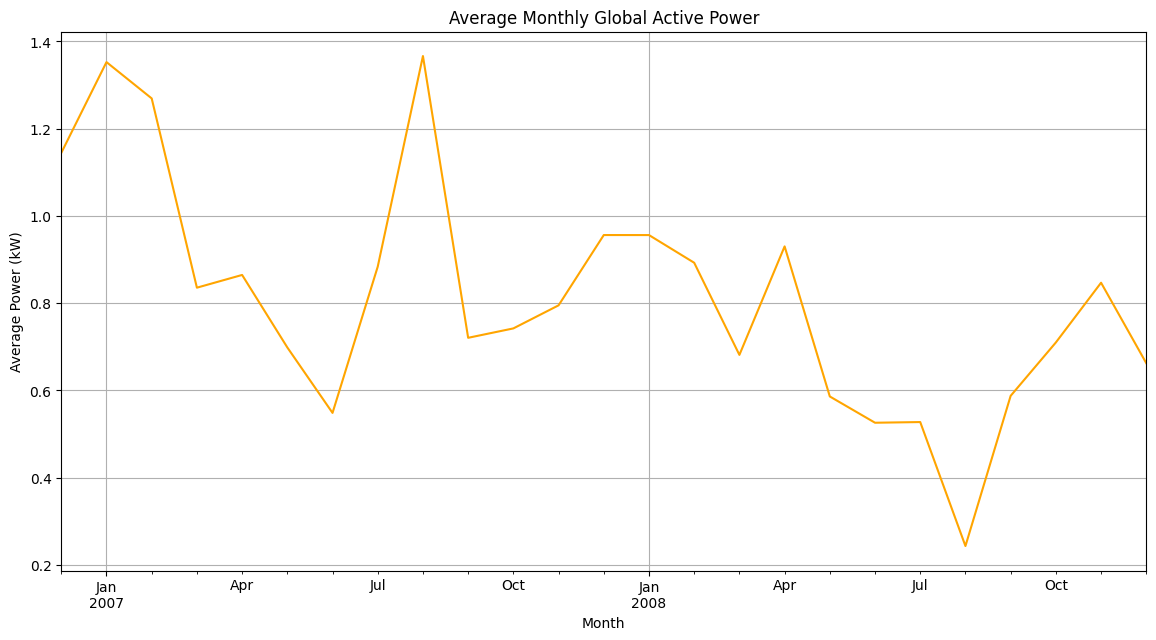

In [25]:
# Calculate monthly average consumption
monthly_consumption = merged_df.resample('ME')['Global_active_power'].mean()

# Plot monthly average consumption
plt.figure(figsize=(14, 7))
monthly_consumption.plot(color='orange')
plt.title('Average Monthly Global Active Power')
plt.xlabel('Month')
plt.ylabel('Average Power (kW)')
plt.grid()
plt.show()

**Correlation Analysis**

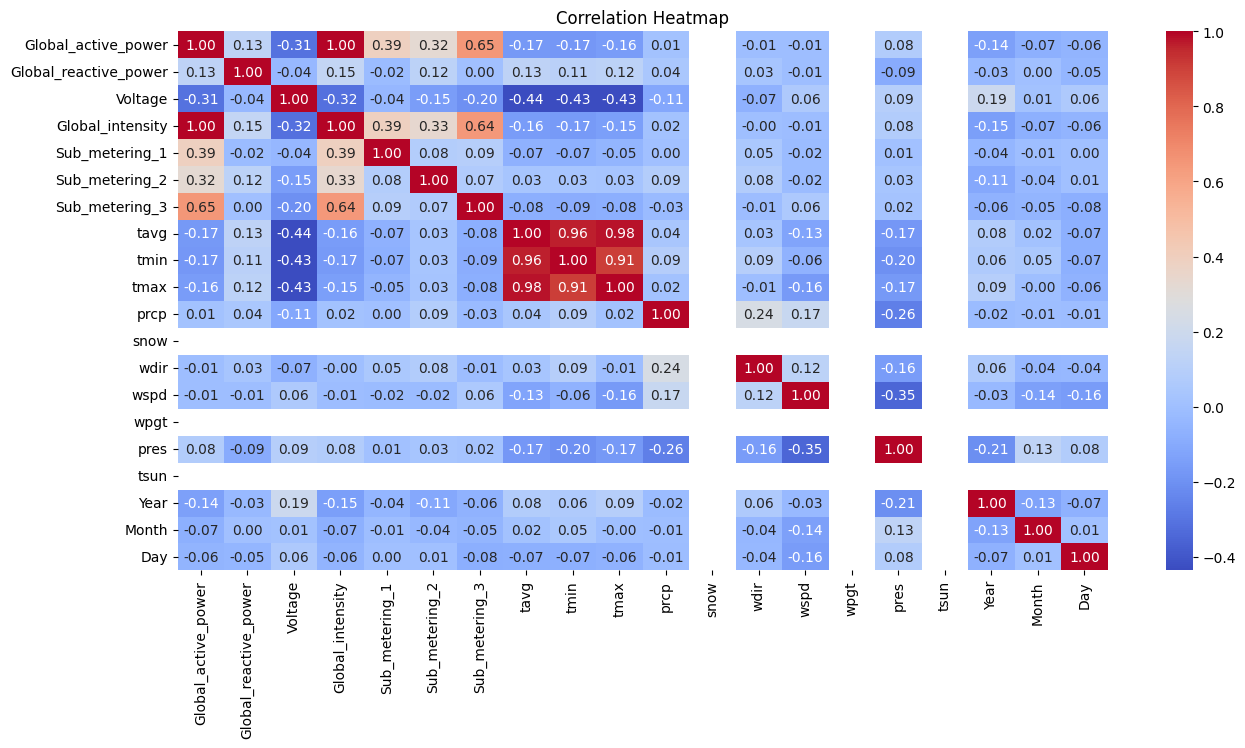

In [26]:
# Correlation heatmap to analyze feature relationships
correlation_matrix = merged_df.corr()
plt.figure(figsize=(15,7))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

**Weather Impact Analysis**

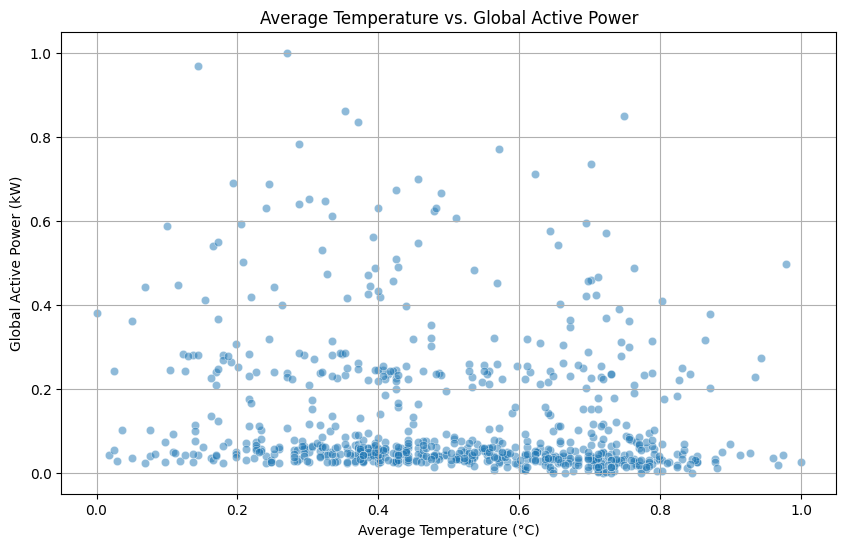

In [80]:
# Analyze the impact of average temperature on energy consumption
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='tavg', y='Global_active_power', alpha=0.5)
plt.title('Average Temperature vs. Global Active Power')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Global Active Power (kW)')
plt.grid()
plt.show()

**Energy Consumption per month**

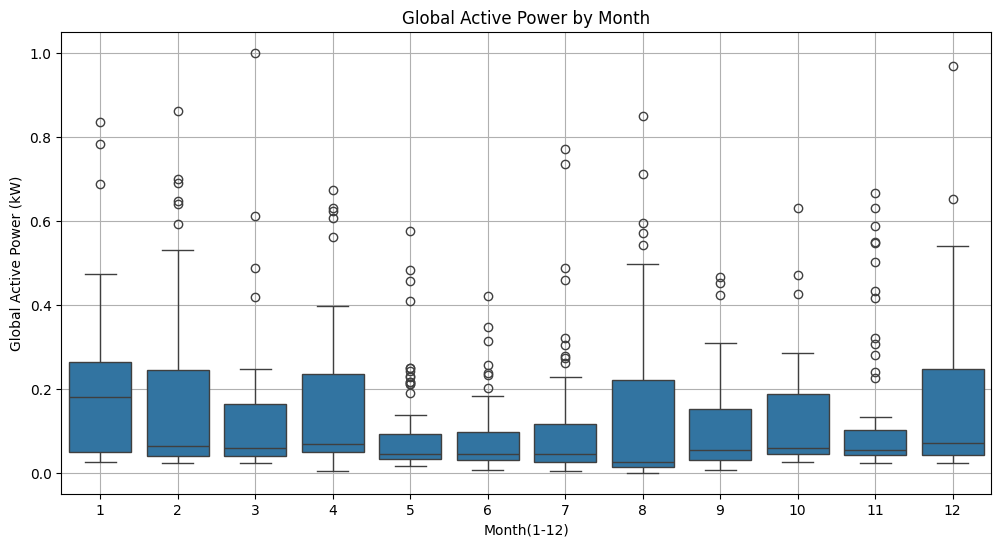

In [81]:
# Boxplot to visualize energy consumption by month
plt.figure(figsize=(12, 6))
sns.boxplot(x='Month', y='Global_active_power', data=merged_df)
plt.title('Global Active Power by Month')
plt.xlabel('Month(1-12)')
plt.ylabel('Global Active Power (kW)')
plt.grid()
plt.show()

**Energy Consumption per year**

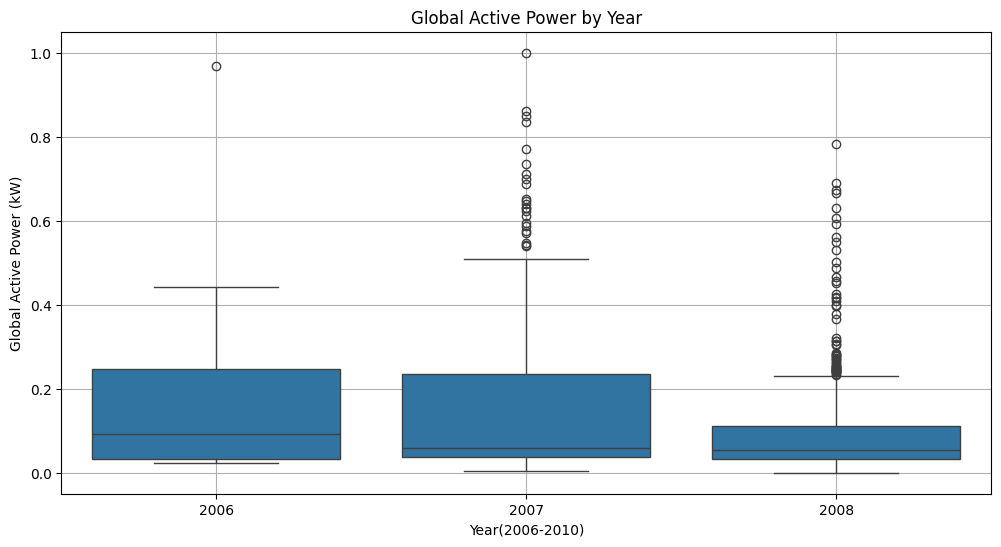

In [82]:
# Boxplot to visualize energy consumption by year
plt.figure(figsize=(12, 6))
sns.boxplot(x='Year', y='Global_active_power', data=merged_df)
plt.title('Global Active Power by Year')
plt.xlabel('Year(2006-2010)')
plt.ylabel('Global Active Power (kW)')
plt.grid()
plt.show()

**Model Training and Evaluation**

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# Define features and target
X = merged_df.drop(columns=['Global_active_power'])  # Drop target and non-feature columns
y = merged_df['Global_active_power'] # Drop target and non-feature columns
# Split the dataset into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Using Linear Regression**

In [73]:
# Initialize the Linear Regression model
linear_model = LinearRegression()

# Fit the model to the training data
linear_model.fit(X_train, y_train)

LinearRegression()

In [74]:
# Predict on the test set
y_pred = linear_model.predict(X_test)

In [75]:
y_train_pred = linear_model.predict(X_train)  # Predictions on training data
y_test_pred = linear_model.predict(X_test)      # Predictions on validation data

In [76]:
# Evaluating performance using RMSE,MAE and R2:
from sklearn.metrics import root_mean_squared_error
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r_squared = linear_model.score(X_test, y_test)

print(f'RMSE: {rmse}\nMAE: {mae}\nR-squared: {r_squared}')

RMSE: 0.006259596852138858
MAE: 0.004170441991561114
R-squared: 0.9983898128601771


In [77]:
# For regression
train_rmse = root_mean_squared_error(y_train, y_train_pred)
val_rmse = root_mean_squared_error(y_test, y_test_pred)
print(f'Train RMSE: {train_rmse}, Validation RMSE: {val_rmse}')


Train RMSE: 0.005579155717131026, Validation RMSE: 0.006259596852138858


**Tried using L1 Regularization (Lasso)**

In [78]:
from sklearn.linear_model import Lasso
#apply lasso regression
lasso= Lasso(alpha=0.1)
lasso.fit(X_train,y_train)

#predict and evaluate
y_pred=lasso.predict(X_test)
mse=root_mean_squared_error(y_test,y_pred)

print("Mean squared error: ",mse)
print("Coefficients: ",lasso.coef_)

Mean squared error:  0.09960004831574423
Coefficients:  [-0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -2.12881892e-05  0.00000000e+00
  3.25791246e-04 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  1.06279414e-02  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00]


**Tried using L2 Regularization (Ridge)**

In [79]:
from sklearn.linear_model import Ridge
from sklearn.datasets import make_regression

alpha=1.0 #Regularization strength
ridge=Ridge(alpha=alpha)
ridge.fit(X_train,y_train)

#Predict and evaluate
y_pred=ridge.predict(X_test)
rmse=root_mean_squared_error(y_test,y_pred)
print("Mean squared error: ",rmse)
print("Coefficients: ",ridge.coef_)

Mean squared error:  0.019319566236482653
Coefficients:  [-2.09087612e-03 -2.63007423e-02  7.16910701e-01  6.33527579e-02
  2.23962667e-02  3.46274794e-02 -4.38433358e-02 -7.96649818e-03
 -2.35770860e-02  9.11026971e-05 -1.72263593e-05  7.67463811e-05
  1.74293331e-04  1.57686353e-03 -2.92237478e-04  1.71640072e-04
  2.72647609e-03  6.64526393e-03  3.40304203e-04  3.17303444e-03
 -1.85107703e-03]
